## Exploring Flight Delays: A Data Modeling and Analysis Approach for Predicting Causes for Delays in Airline On-time Data

## Names

* Aditya Tomar
* Shay Samat
* Akhil Vasanth


# Preprocessing

In [2]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.formula.api import logit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


In [3]:
csv_files = []
years = [2018, 2019, 2022]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in years:
    for month in months:
        csv_file = "data/{:02d}_{}.csv".format(int(month), year)
        csv_files.append(csv_file)

dfs = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

flights = pd.concat(dfs, ignore_index=True)
flights.head()


,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_CITY_NAME,DEST_STATE_ABR,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_STATE_NM,DEST_STATE_NM
0,1/1/2018 12:00:00 AM,9E,"Albany, GA",GA,"Atlanta, GA",GA,0.0,0.0,54.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2018 12:00:00 AM,9E,"Albany, GA",GA,"Atlanta, GA",GA,0.0,0.0,55.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA",LA,"Atlanta, GA",GA,0.0,0.0,92.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA",LA,"Atlanta, GA",GA,39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0,NaN,NaN
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI",WI,"Minneapolis, MN",MN,0.0,0.0,65.0,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
# dropping columns/features we aren't using
flights = flights.drop(["ORIGIN_STATE_ABR", "DEST_STATE_ABR","ORIGIN_STATE_NM","DEST_STATE_NM"], axis=1)


KeyError: "['ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_STATE_NM'] not found in axis"

In [5]:
#creating a month feature and year feature
flights['MONTH'] = [int(row.split('/')[0]) for row in flights['FL_DATE']]
flights['YEAR'] = [int(row.split('/')[2].split(' ')[0]) for row in flights['FL_DATE']]


0            1
1            1
2            1
3            1
4            1
            ..
21357352    12
21357353    12
21357354    12
21357355    12
21357356    12
Name: MONTH, Length: 21357357, dtype: int64 0           2018
1           2018
2           2018
3           2018
4           2018
            ... 
21357352    2022
21357353    2022
21357354    2022
21357355    2022
21357356    2022
Name: YEAR, Length: 21357357, dtype: int64


In [6]:
delay_columns = [col for col in flights.columns if "DELAY" in col]
flights[delay_columns] = flights[delay_columns].fillna(0)

In [8]:
#creating the TOTAL_DELAY feature, the sum of arrival and departure delay
flights['TOTAL_DELAY'] = flights['ARR_DELAY_NEW'] + flights['DEP_DELAY_NEW']


,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,MONTH,YEAR,TOTAL_DELAY
0,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,54.0,145.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0
1,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,55.0,145.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0,1,2018,62.0
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI","Minneapolis, MN",0.0,0.0,65.0,236.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21357352,12/31/2022 12:00:00 AM,YX,"Washington, DC","Raleigh/Durham, NC",0.0,0.0,71.0,227.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0
21357353,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,NaN,500.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0
21357354,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0
21357355,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","Newark, NJ",0.0,0.0,100.0,488.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0


In [9]:
#create the DELAY_STATUS variable, which we will use as our class labels for each sample

delay_status = ['1' if (row > 0) else '0' for row in flights['TOTAL_DELAY']]
flights['DELAY_STATUS'] = delay_status


,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,MONTH,YEAR,TOTAL_DELAY,DELAY_STATUS
0,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,54.0,145.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0,0
1,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,55.0,145.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0,0
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0,0
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0,1,2018,62.0,1
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI","Minneapolis, MN",0.0,0.0,65.0,236.0,0.0,0.0,0.0,0.0,0.0,1,2018,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21357352,12/31/2022 12:00:00 AM,YX,"Washington, DC","Raleigh/Durham, NC",0.0,0.0,71.0,227.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0,0
21357353,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,NaN,500.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0,0
21357354,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0,0
21357355,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","Newark, NJ",0.0,0.0,100.0,488.0,0.0,0.0,0.0,0.0,0.0,12,2022,0.0,0


In [14]:
#drop samples with missing/NaN values
flights = flights.dropna()

# Get the top 20 most common cities in 'ORIGIN_CITY_NAME'
top_origin_cities = flights['ORIGIN_CITY_NAME'].value_counts().nlargest(25).index

# Get the top 20 most common cities in 'DEST_CITY_NAME'
top_dest_cities = flights['DEST_CITY_NAME'].value_counts().nlargest(25).index

# Filter the DataFrame to include only the data for the top origin cities and top destination cities
filtered_data = flights[(flights['ORIGIN_CITY_NAME'].isin(top_origin_cities)) & (flights['DEST_CITY_NAME'].isin(top_dest_cities))]



In [15]:
#random sample 50,000 datapoints
filtered_data = filtered_data.sample(n=50000, replace = False, random_state = 42)



(50000, 17)

In [16]:
#One hot Encoding of Categorical Data

# Perform one-hot encoding for 'ORIGIN_CITY_NAME' with the top origin cities
origin_city_encoded = pd.get_dummies(filtered_data['ORIGIN_CITY_NAME'], prefix='OriginCity')

# Perform one-hot encoding for 'DEST_CITY_NAME' with the top destination cities
dest_city_encoded = pd.get_dummies(filtered_data['DEST_CITY_NAME'], prefix='DestCity')

# Perform one-hot encoding for 'OP_UNIQUE_CARRIER'
carrier_encoded = pd.get_dummies(filtered_data['OP_UNIQUE_CARRIER'], prefix='Carrier')

# Perform one-hot encoding for 'MONTH'
month_encoded = pd.get_dummies(filtered_data['MONTH'], prefix='Month')

# Perform one-hot encoding for 'YEAR'
year_encoded = pd.get_dummies(filtered_data['YEAR'], prefix='YEAR')

# Concatenate the one-hot encoded columns with the original DataFrame
encoded_data = pd.concat([filtered_data, origin_city_encoded, dest_city_encoded, carrier_encoded, month_encoded,
                           year_encoded], axis=1)

# Drop the original categorical columns from the encoded DataFrame
encoded_data = encoded_data.drop(['ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'OP_UNIQUE_CARRIER'], axis=1)
delay_columns = [col for col in flights.columns if "DELAY" in col]
delay_columns.remove('DELAY_STATUS')
encoded_data = encoded_data.drop(columns=delay_columns, axis=1)
encoded_data = encoded_data.drop(columns=['FL_DATE', 'ACTUAL_ELAPSED_TIME', 'MONTH', 'YEAR'])


# Scale the data

encoded_data.columns

Index(['DISTANCE', 'DELAY_STATUS', 'OriginCity_Atlanta, GA',
       'OriginCity_Baltimore, MD', 'OriginCity_Boston, MA',
       'OriginCity_Charlotte, NC', 'OriginCity_Chicago, IL',
       'OriginCity_Dallas/Fort Worth, TX', 'OriginCity_Denver, CO',
       'OriginCity_Detroit, MI', 'OriginCity_Fort Lauderdale, FL',
       'OriginCity_Houston, TX', 'OriginCity_Las Vegas, NV',
       'OriginCity_Los Angeles, CA', 'OriginCity_Miami, FL',
       'OriginCity_Minneapolis, MN', 'OriginCity_Nashville, TN',
       'OriginCity_New York, NY', 'OriginCity_Newark, NJ',
       'OriginCity_Orlando, FL', 'OriginCity_Philadelphia, PA',
       'OriginCity_Phoenix, AZ', 'OriginCity_Salt Lake City, UT',
       'OriginCity_San Diego, CA', 'OriginCity_San Francisco, CA',
       'OriginCity_Seattle, WA', 'OriginCity_Washington, DC',
       'DestCity_Atlanta, GA', 'DestCity_Baltimore, MD', 'DestCity_Boston, MA',
       'DestCity_Charlotte, NC', 'DestCity_Chicago, IL',
       'DestCity_Dallas/Fort Worth, TX', 

# EDA

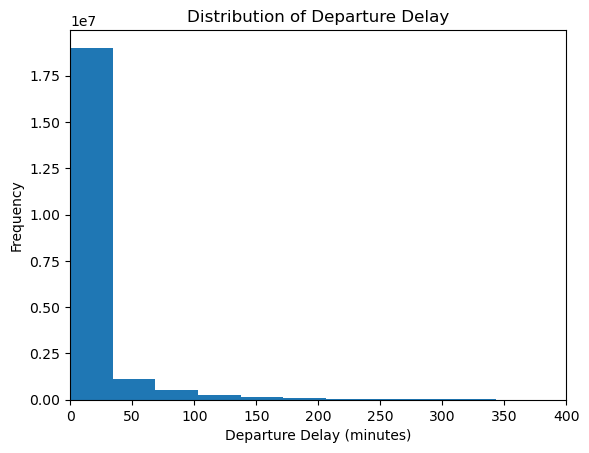

In [11]:
# Distribution of departure delay
plt.hist(flights['DEP_DELAY_NEW'], bins=100)
plt.xlim(0,400)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Departure Delay')
plt.show()

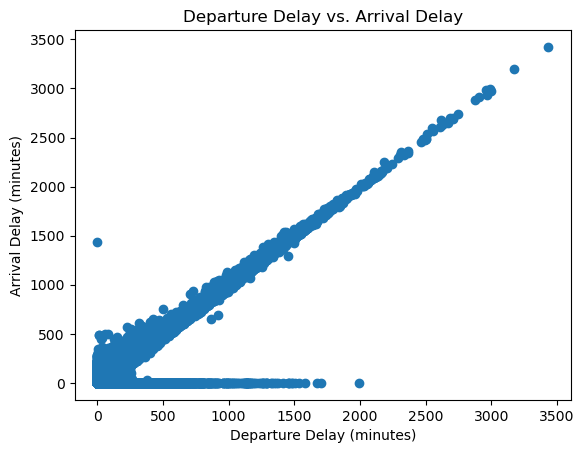

In [12]:
plt.scatter(flights['DEP_DELAY_NEW'], flights['ARR_DELAY_NEW'])
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Departure Delay vs. Arrival Delay')
plt.show()

In [13]:
avg_dep_delay_by_city = flights.groupby('ORIGIN_CITY_NAME')['DEP_DELAY_NEW'].mean()

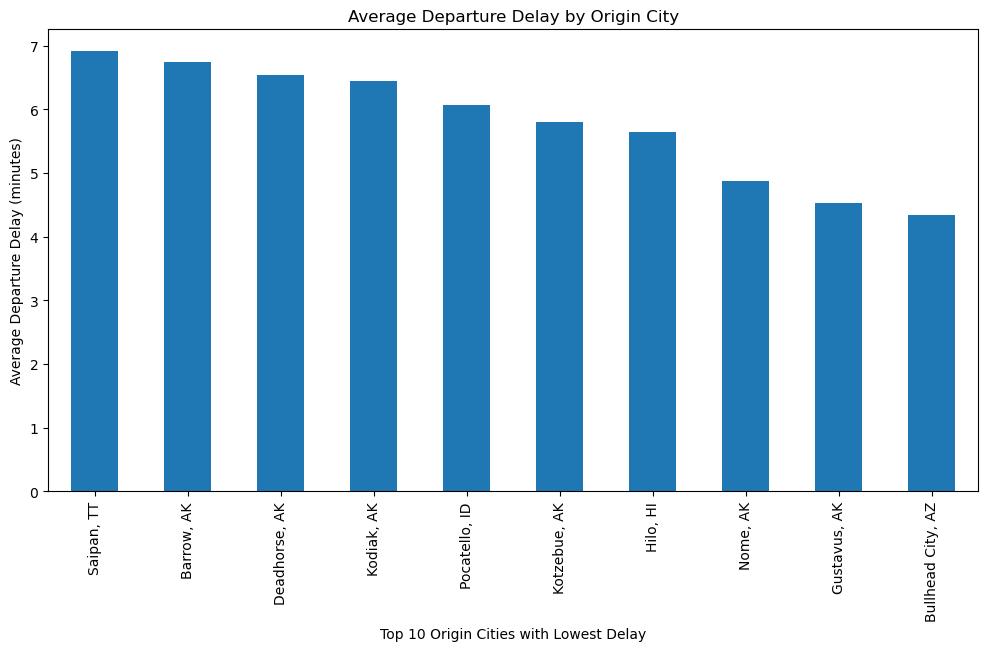

In [14]:
plt.figure(figsize=(12, 6))
avg_dep_delay_by_city.sort_values(ascending=False)[-10:].plot(kind='bar')
plt.xlabel('Top 10 Origin Cities with Lowest Delay')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Origin City')
plt.show()

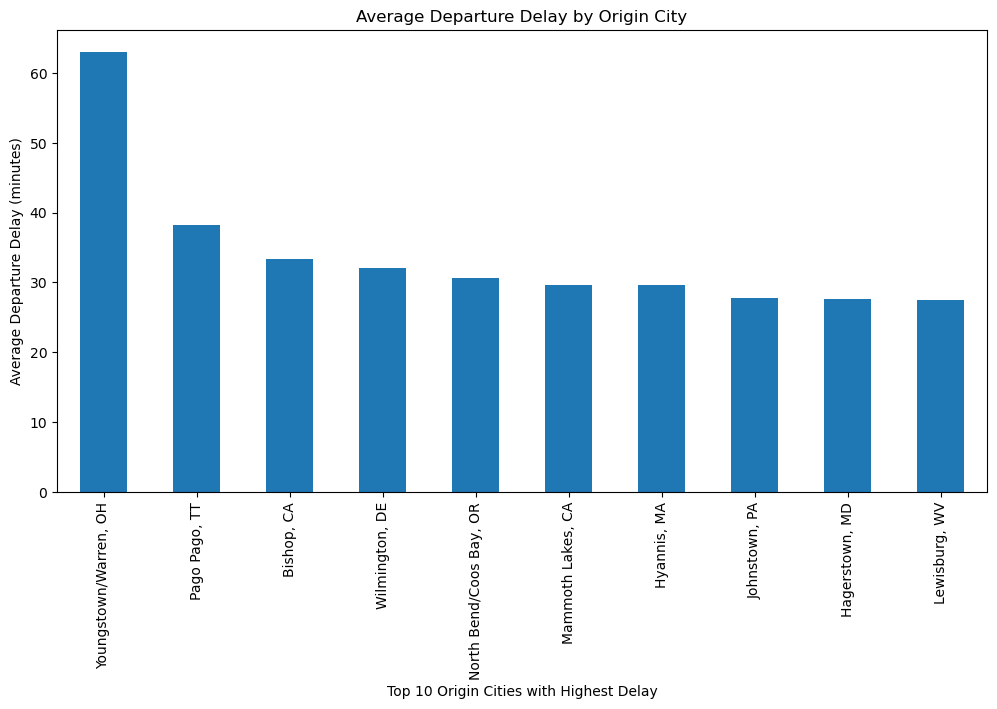

In [15]:
plt.figure(figsize=(12, 6))
avg_dep_delay_by_city.sort_values(ascending=False)[0:10].plot(kind='bar')
plt.xlabel('Top 10 Origin Cities with Highest Delay')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Origin City')
plt.show()

In [16]:
correlation = flights[['TOTAL_DELAY', 'DISTANCE']].corr()
print(correlation)

             TOTAL_DELAY  DISTANCE
TOTAL_DELAY     1.000000  0.009457
DISTANCE        0.009457  1.000000


# Time series analysis - Total delay over time

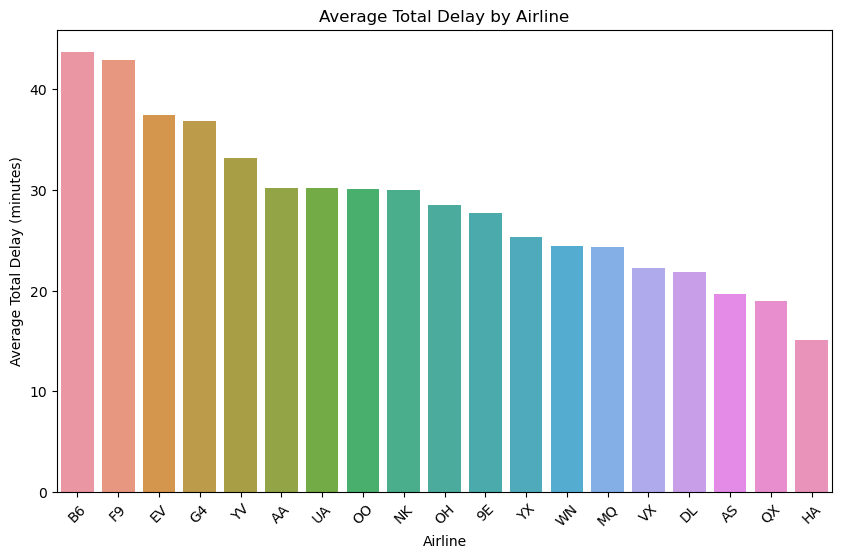

In [17]:
# Comparison analysis - Average total delay by airline
avg_delay_by_airline = flights.groupby('OP_UNIQUE_CARRIER')['TOTAL_DELAY'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delay_by_airline.index, y=avg_delay_by_airline.values)
plt.xlabel('Airline')
plt.ylabel('Average Total Delay (minutes)')
plt.title('Average Total Delay by Airline')
plt.xticks(rotation=45)
plt.show()

# Scatter plot - Delay vs. distance

flights['Year'] = flights['FL_DATE'].dt.year
flights['Month'] = flights['FL_DATE'].dt.month

fig, axs = plt.subplots(nrows=len(flights['Year'].unique()), figsize=(12, 8), sharex=True, sharey=True)

for i, year in enumerate(flights['Year'].unique()):
    subset = flights[flights['Year'] == year]
    
    monthly_delay = subset.groupby('Month')['TOTAL_DELAY'].sum()
    flight_counts = subset['Month'].value_counts()
    
    monthly_mean_delay = monthly_delay / flight_counts
    
    axs[i].scatter(monthly_mean_delay.index, monthly_mean_delay.values)
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Average Delay (minutes)')
    axs[i].set_title(f'Average Delay Over Time - {year}')
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axs[i].set_xticks(range(1, 13))
    axs[i].set_xticklabels(months)

plt.suptitle('Mean Total Delay Over Time (Separated by Month and Year)')
plt.tight_layout()
plt.show()

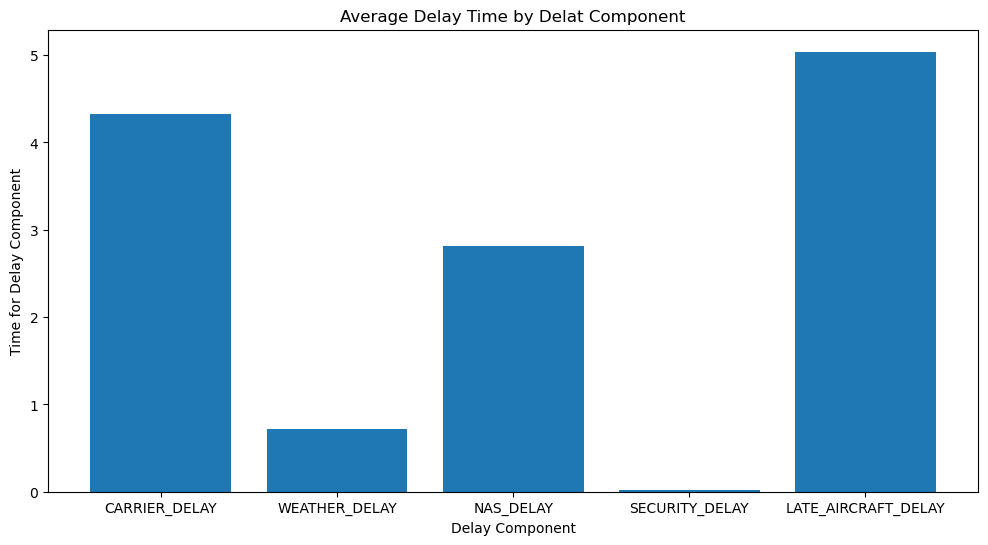

In [18]:
# Stacked bar plot - Delay components
delay_components = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
delay_sums = flights[delay_components].sum()
delay_components_times = []
for component in delay_components:
    delay_components_times.append(flights[component].mean())

plt.figure(figsize=(12, 6))
plt.bar(delay_components, delay_components_times)
plt.xlabel('Delay Component')
plt.ylabel('Time for Delay Component')
plt.title('Average Delay Time by Delat Component')
plt.show()

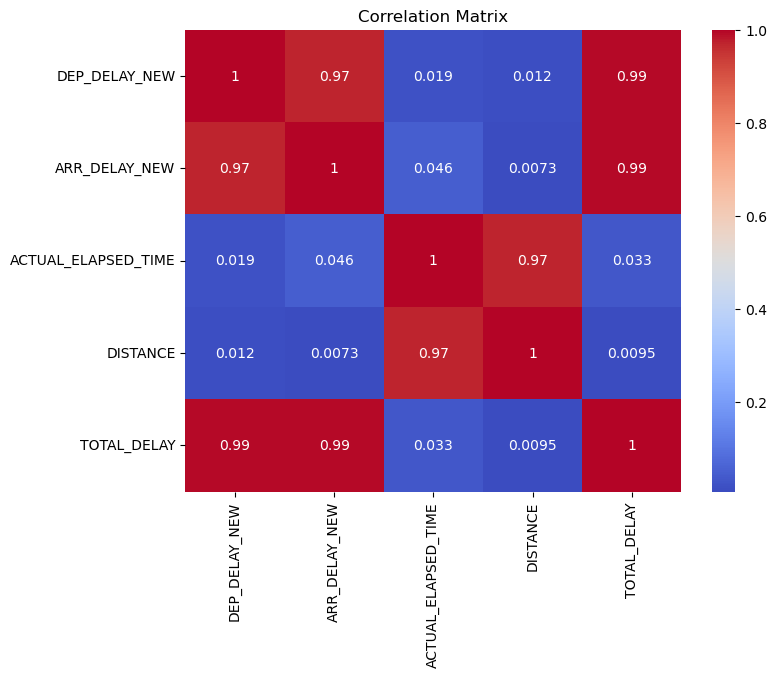

In [19]:
# Heatmap - Correlation matrix
correlation_matrix = flights[['DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'TOTAL_DELAY']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Model Selection/Estimation

In [17]:
X = encoded_data.drop(columns=["DELAY_STATUS"])
y = encoded_data['DELAY_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(84,)


c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(84,)


c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(84,)


c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(84,)


c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\akhil\anaconda3\envs\env38\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(84,)


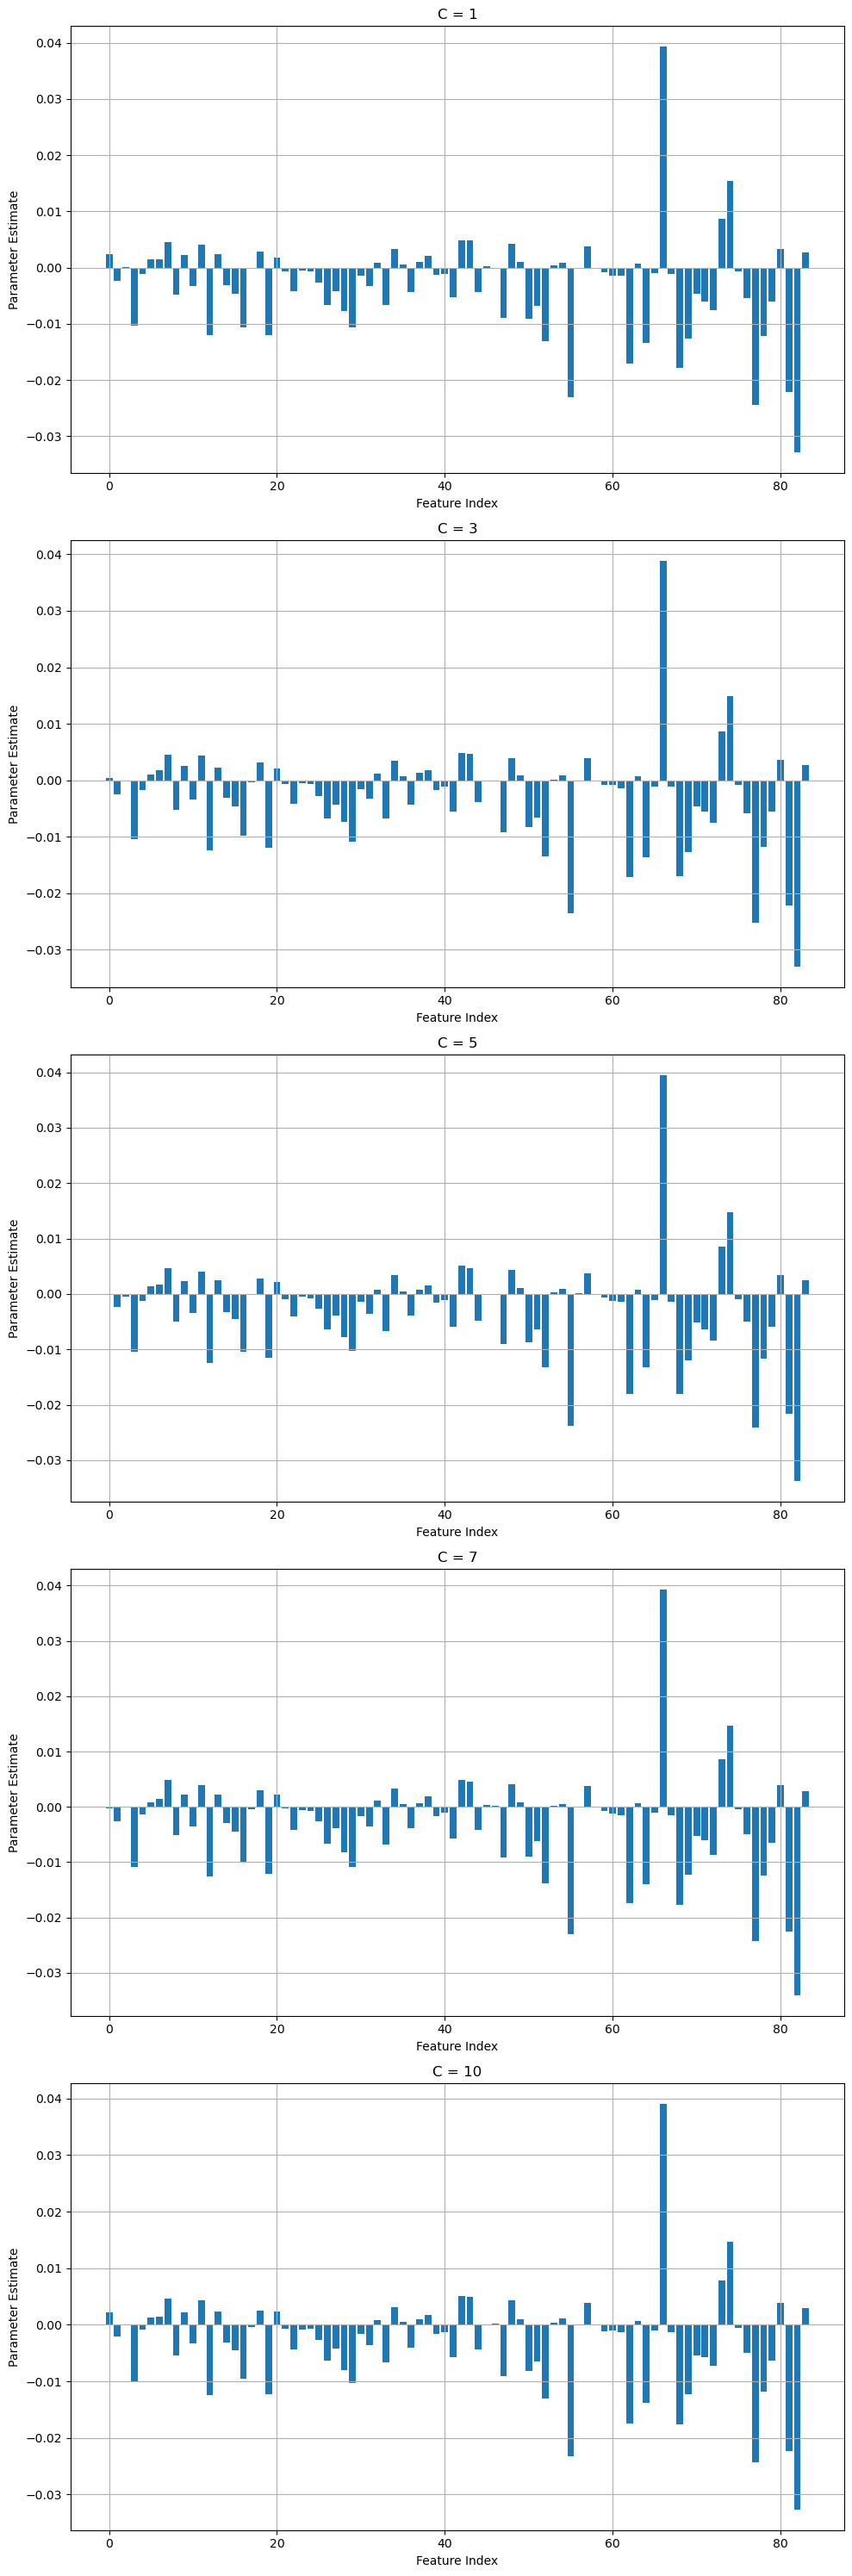

In [95]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

c_values = [1, 3, 5, 7, 10]
coefs_list = []
accuracies = []

# Fit the models separately and save the coefficient estimates to a list
for c in c_values:
    svm_model = LinearSVC(C=c, max_iter = 10)
    cv_scores = cross_validate(svm_model, X, y, cv=5, return_estimator=True)
    estimators = cv_scores['estimator']
    mean_score = cv_scores['test_score'].mean()


    coefs = [estimator.coef_[0] for estimator in estimators]
    avg_coefs = np.mean(coefs, axis=0)
    
    coefs_list.append(avg_coefs)
    accuracies.append(mean_score)


# Create separate plots for each C value
num_features = len(coefs_list[0])
num_c_values = len(c_values)
fig, axes = plt.subplots(num_c_values, 1, figsize=(10, 6*num_c_values))

# Plot the bar plots for each C value
for i, ax in enumerate(axes):
    coefs = coefs_list[i]
    ax.bar(range(num_features), coefs)
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Parameter Estimate')
    ax.set_title(f'C = {c_values[i]}')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [96]:
print("Top 10 Features With the Biggest Parameter Estimates For Each C Value(greatest to least): \n")
for i in range(len(coefs_list)):
    coefs = coefs_list[i]
    top_ten_indices = np.argsort(coefs)[-10:]
    top_ten_indices = np.flip(top_ten_indices)
    top_ten_features = [list(X.columns)[i] for i in top_ten_indices]
    
    print("C = " + str(c_values[i]) + ": \n" + str(top_ten_features))



Top 10 Features With the Biggest Parameter Estimates For Each C Value(greatest to least): 

C = 1: 
['Carrier_WN', 'Month_6', 'Month_5', 'DestCity_Newark, NJ', 'DestCity_Orlando, FL', 'OriginCity_Denver, CO', 'DestCity_San Francisco, CA', 'OriginCity_Las Vegas, NV', 'Carrier_F9', 'DestCity_Fort Lauderdale, FL']
C = 3: 
['Carrier_WN', 'Month_6', 'Month_5', 'DestCity_Newark, NJ', 'DestCity_Orlando, FL', 'OriginCity_Denver, CO', 'OriginCity_Las Vegas, NV', 'DestCity_San Francisco, CA', 'Carrier_F9', 'Month_12']
C = 5: 
['Carrier_WN', 'Month_6', 'Month_5', 'DestCity_Newark, NJ', 'DestCity_Orlando, FL', 'OriginCity_Denver, CO', 'DestCity_San Francisco, CA', 'OriginCity_Las Vegas, NV', 'Carrier_F9', 'DestCity_Fort Lauderdale, FL']
C = 7: 
['Carrier_WN', 'Month_6', 'Month_5', 'DestCity_Newark, NJ', 'OriginCity_Denver, CO', 'DestCity_Orlando, FL', 'DestCity_San Francisco, CA', 'Month_12', 'OriginCity_Las Vegas, NV', 'Carrier_F9']
C = 10: 
['Carrier_WN', 'Month_6', 'Month_5', 'DestCity_Newark, 

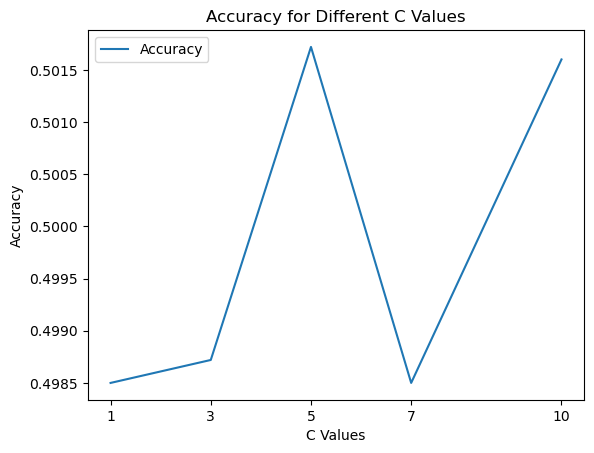

In [98]:
# Plot the progression of C values against accuracy
plt.plot(c_values, accuracies, label='Accuracy')
plt.xlabel('C Values')
plt.xticks(c_values)
plt.ylabel('Accuracy')
plt.title('Accuracy for Different C Values')

plt.legend()